# Predicting Credit Risk For Loans

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve,
    accuracy_score,
    precision_score, 
    recall_score,
    roc_auc_score,
    classification_report
)

In [49]:
df = pd.read_csv("datasets/credit_risk_dataset.csv")

### Light EDA

In [50]:
df.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
12338,24,80000,OWN,0.0,VENTURE,A,5500,8.94,0,0.07,N,2
5351,22,42000,RENT,3.0,EDUCATION,B,8500,12.53,0,0.20,N,4
18332,29,20000,OWN,1.0,EDUCATION,A,5000,5.79,0,0.25,N,7
979,22,48000,RENT,5.0,EDUCATION,B,18000,NaN,1,0.38,N,2
6504,26,50000,OWN,10.0,VENTURE,A,9825,7.90,0,0.20,N,4


In [51]:
df.shape

(32581, 12)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [53]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [54]:
df.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [55]:
df.isna().mean()

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027470
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095639
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [56]:
df.duplicated().sum()

165

We will want to drop duplicated rows.

Almost 10% of `loan_int_rate` has missing values. Let's impute everything with the mean later. 

### Preprocessing & Feature Engineering

In [57]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(32416, 12)

In [58]:
# Fill na values with the respected means
df['person_emp_length'].fillna(df['person_emp_length'].mean(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].mean(), inplace=True)
df.shape

(32416, 12)

In [59]:
# Encode categorical variables
loan_grade_mapping = {
    'A': 1,
    'B': 2,
    'C': 3, 
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

df['loan_grade'] = df['loan_grade'].replace(loan_grade_mapping)
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)
df.sample(5)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
21607,35,36500,0.0,3,6000,13.61,0,0.16,6,False,False,True,False,False,True,False,False,False
30223,39,44500,5.0,1,6000,7.88,0,0.13,17,False,False,True,False,False,True,False,False,False
20316,32,115000,2.0,2,4000,12.69,0,0.03,10,False,False,True,True,False,False,False,False,False
2883,26,54400,2.0,5,3000,19.42,1,0.05,2,False,False,True,False,False,True,False,False,False
19522,31,54050,8.0,2,12000,10.99,0,0.22,9,False,False,True,False,False,False,True,False,False


Note: Dropping one category (i.e., using drop_first=True) is a common practice, especially in linear models, to avoid the dummy variable trap. A dummy variable trap is a scenario where the model can become overfit or unstable due to multicollinearity.

In [60]:
# Scale continuous features
scaler = StandardScaler()
continuous_cols = [col for col in df.columns if df[col].nunique() > 5]
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
df.sample(5)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
5038,-0.432327,-0.311082,1.029639,-1.045605,-0.726572,-1.380887,0,-0.564083,-0.692614,False,False,True,False,False,True,False,False,False
9073,-0.747089,-0.098229,-0.437958,-0.188909,-0.252086,-0.248870,0,-0.376835,-0.692614,False,False,True,True,False,False,False,False,False
1280,-0.904471,-0.219168,-0.927157,-0.188909,1.013210,0.542569,1,1.214771,-0.692614,False,False,True,False,False,True,False,False,False
16439,-0.432327,-0.307857,1.029639,-1.045605,-0.884734,-1.426298,0,-0.751331,-0.938982,False,True,False,False,False,False,False,True,False
28527,0.826722,0.163774,2.986436,-1.045605,0.127503,-1.088963,0,-0.283211,-0.199878,False,False,False,True,False,False,False,False,False


### Model Building

In [61]:
# Split the data into features and target
TARGET = 'loan_status'
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [62]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Train and evaluate the first model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of True

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy*100: .1f}% | Precision:{precision*100: .1f}% | Recall:{recall*100: .1f}% | ROC_AUC:{roc_auc*100: .1f}%')

Accuracy:  85.0% | Precision: 73.6% | Recall: 48.8% | ROC_AUC: 71.9%


In [64]:
# Train and evaluate the second model
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of True

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy*100: .1f}% | Precision:{precision*100: .1f}% | Recall:{recall*100: .1f}% | ROC_AUC:{roc_auc*100: .1f}%')

Accuracy:  93.4% | Precision: 97.2% | Recall: 71.5% | ROC_AUC: 85.5%


It's clear that the Random Forest Classifier outperforms logistic regression, so we'll proceed with Random Forest for our analysis.

### Model Evaluation

In [65]:
# Generate classification report summary
class_report = classification_report(y_test, y_pred, target_names=['No Default', 'Default'])
print(class_report)

              precision    recall  f1-score   support

  No Default       0.93      0.99      0.96      5073
     Default       0.97      0.72      0.82      1411

    accuracy                           0.93      6484
   macro avg       0.95      0.85      0.89      6484
weighted avg       0.94      0.93      0.93      6484



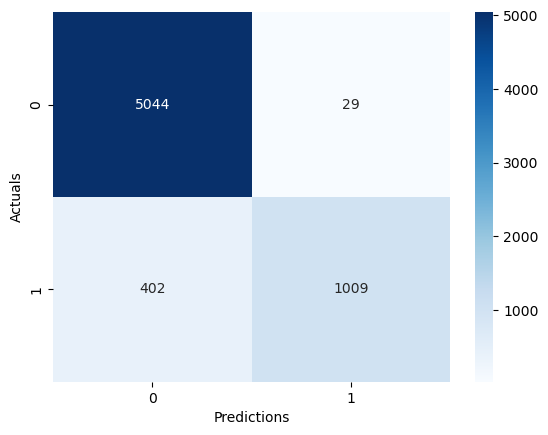

In [66]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g') # 'g' ensures normal integer format
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show()

The confusion matrix shows that the model is highly effective at correctly identifying the negative class (5032 true negatives) but faces challenges with the positive class, resulting in 390 false negatives. In this scenario, a false negative occurs when the model predicts that the customer will not default, but they actually do. This could be a significant issue, as it means the model is missing instances where customers are likely to default.

In [67]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test , y_pred)

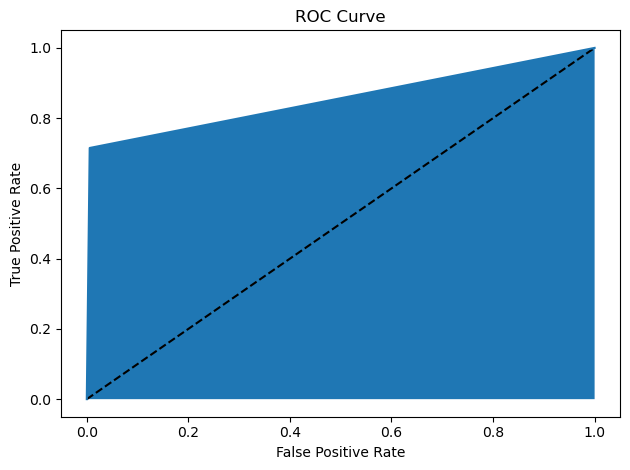

In [68]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.fill_between(fpr, tpr)
plt.tight_layout()
plt.show()

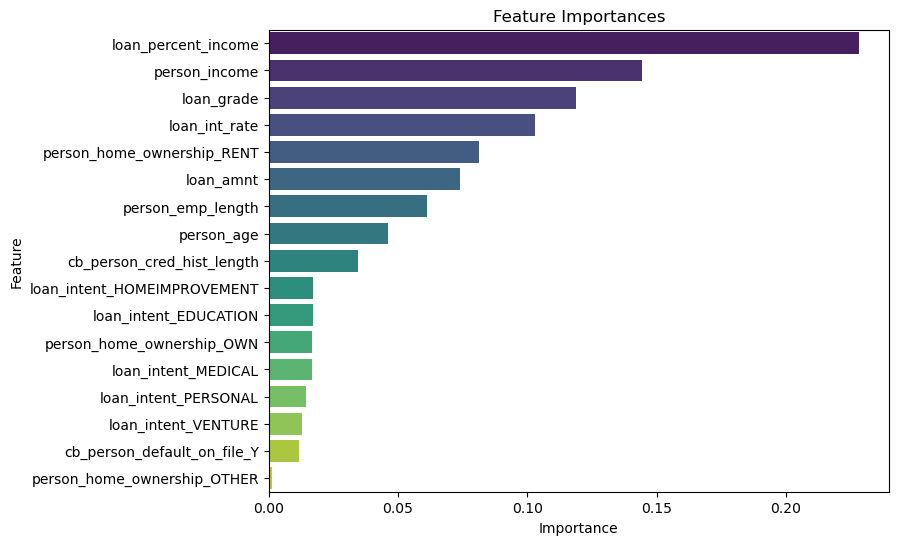

In [69]:
# Plot feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The feature importance plot indicates that loan_percent_income and person_income are the most influential factors in predicting the outcome, with the highest importance scores. These features significantly impact the model’s decisions, suggesting that the proportion of income dedicated to loan repayment and the overall income of the person are key predictors of loan default risk.